In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from IPython.display import display
import glob
from tqdm import tqdm
import os

In [34]:
precovid_folder = "/Users/sarahyuhan/BostonBusEquity/2015-2017-tables"
#all the export files in 2015-2017
file_paths = glob.glob(os.path.join(precovid_folder, '*export.xlsx'))

df_list = [pd.read_excel(file) for file in file_paths]
df_pre = pd.concat(df_list, ignore_index=True)

df_pre.head()

postcovid = "/Users/sarahyuhan/BostonBusEquity/2023.csv"
df_post = pd.read_csv(postcovid)
df_post = df_post[df_post['service_mode'] == 'Bus']

In [35]:
df_pre.head(),df_post.head()

(          Route  Trip Purpose: Home-based work  \
 0  line-all-bus                           70.0   
 1             1                           65.0   
 2           100                           62.0   
 3           101                           75.0   
 4           104                           84.0   
 
    Trip Purpose: Home-based school  Trip Purpose: Home-based social activity  \
 0                              8.0                                       4.0   
 1                              9.0                                       7.0   
 2                              8.0                                       9.0   
 3                              9.0                                       2.0   
 4                              7.0                                       1.0   
 
    Trip Purpose: Home-based other  Trip Purpose: Non-home-based  \
 0                            12.0                           6.0   
 1                             9.0                          10.0   


In [36]:
df_pre_numeric = df_pre.drop(columns=["Mode"], errors="ignore").apply(pd.to_numeric, errors="coerce")

# mapping of categories from df_post
df_post.columns = df_post.columns.str.strip().str.lower()
df_post['full_category'] = df_post['measure_group'] + ": " + df_post['category']

category_mapping = df_post[['category', 'full_category']].drop_duplicates().set_index('category').to_dict()['full_category']

# Rename df_pre columns using this mapping
df_post.rename(columns=lambda x: x.strip(), inplace=True)
df_post.rename(columns={
    'weighted_percent': 'percentage'
}, inplace=True)


df_pre.columns, df_post.columns


(Index(['Route', 'Trip Purpose: Home-based work',
        'Trip Purpose: Home-based school',
        'Trip Purpose: Home-based social activity',
        'Trip Purpose: Home-based other', 'Trip Purpose: Non-home-based',
        'Trip Frequency: 6-7 days a week', 'Trip Frequency: 5 days a week',
        'Trip Frequency: 3-4 days a week', 'Trip Frequency: 1-2 days a week',
        'Trip Frequency: 1-3 days a month',
        'Trip Frequency: Less than once a month', 'Income: Less than $14,500',
        'Income: $14,500 to $28,999', 'Income: $29,000 to $43,499',
        'Income: $43,500 to $57,999', 'Income: $58,000 to $75,999',
        'Income: $76,000 to $108,499', 'Income: $108,500 to $151,999',
        'Income: $152,000 or more', 'Income: Prefer not to say',
        'Low-income: Yes', 'Low-income: No', 'Age: Under 18', 'Age: 18 to 21',
        'Age: 22 to 34', 'Age: 35 to 44', 'Age: 45 to 64', 'Age: 65 or over',
        'Gender: Man', 'Gender: Woman', 'Gender: Other',
        'Gender: P

In [37]:
print(df_pre_numeric.columns.tolist())


['Route', 'Trip Purpose: Home-based work', 'Trip Purpose: Home-based school', 'Trip Purpose: Home-based social activity', 'Trip Purpose: Home-based other', 'Trip Purpose: Non-home-based', 'Trip Frequency: 6-7 days a week', 'Trip Frequency: 5 days a week', 'Trip Frequency: 3-4 days a week', 'Trip Frequency: 1-2 days a week', 'Trip Frequency: 1-3 days a month', 'Trip Frequency: Less than once a month', 'Income: Less than $14,500', 'Income: $14,500 to $28,999', 'Income: $29,000 to $43,499', 'Income: $43,500 to $57,999', 'Income: $58,000 to $75,999', 'Income: $76,000 to $108,499', 'Income: $108,500 to $151,999', 'Income: $152,000 or more', 'Income: Prefer not to say', 'Low-income: Yes', 'Low-income: No', 'Age: Under 18', 'Age: 18 to 21', 'Age: 22 to 34', 'Age: 35 to 44', 'Age: 45 to 64', 'Age: 65 or over', 'Gender: Man', 'Gender: Woman', 'Gender: Other', 'Gender: Prefer not to say', 'English Ability: Always', 'English Ability: Often', 'English Ability: Sometimes', 'English Ability: Never',

In [38]:
print(df_post.isnull().sum())
df_post = df_post.dropna()
df_pre = df_pre.dropna()

aggregation_level    0
service_mode         0
reporting_group      0
measure_group        0
measure              0
category             1
percentage           0
objectid             0
full_category        1
dtype: int64


In [39]:
print("Columns in df_post:", df_post.columns)


Columns in df_post: Index(['aggregation_level', 'service_mode', 'reporting_group', 'measure_group',
       'measure', 'category', 'percentage', 'objectid', 'full_category'],
      dtype='object')


In [49]:
#COMPARING PERCENTAGES in number of people from each category taking the bus pre covid and post covid
# Ensure column names in df_post are standardized
df_post.columns = df_post.columns.str.strip().str.lower()
df_post.rename(columns={'weighted_percent': 'percentage'}, inplace=True)
df_post["percentage"] = df_post["percentage"] * 100


df_post['full_category'] = df_post['measure'] + ": " + df_post['category']

# Extract unique category names from df_post for renaming df_pre
category_mapping = df_post[['category', 'full_category']].drop_duplicates().set_index('category').to_dict()['full_category']

# Drop non-numeric columns from df_pre and convert all to numeric
df_pre_numeric = df_pre.drop(columns=["Mode"], errors="ignore").apply(pd.to_numeric, errors="coerce")

category_totals = df_pre_numeric.groupby(lambda x: x.split(":")[0], axis=1).sum()
pre_percentages = df_pre_numeric.apply(lambda x: (x / category_totals[x.name.split(":")[0]]) * 100 if x.name.split(":")[0] in category_totals else x, axis=0)
pre_percentages = pre_percentages.rename(columns=category_mapping)

# convert to DataFrame for merging
pre_percentages = pre_percentages.T
pre_percentages = pre_percentages.reset_index()
pre_percentages = pre_percentages.rename(columns={pre_percentages.columns[0]: 'pre_covid_percent'})
pre_percentages['full_category'] = pre_percentages.index
pre_percentages = pre_percentages.reset_index(drop=True)


# Ensure both merge columns are strings
pre_percentages["full_category"] = pre_percentages["full_category"].astype(str)
df_post["full_category"] = df_post["full_category"].astype(str)

# Merge with df_post based on full_category
df_comparison = pd.merge(
    pre_percentages,
    df_post[['measure_group', 'full_category', 'percentage']],
    on="full_category",
    how="inner"
)

# create Separate Tables for Each Measure**
grouped_tables = {measure: data for measure, data in df_comparison.groupby("measure_group")}

# display
for measure, table in grouped_tables.items():
    print(f"\nComparison Table for {measure}:")
    display(table)

/var/folders/gh/8gsn76px7tn2s_cff89q_8ww0000gn/T/ipykernel_24400/2762164501.py:17: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  category_totals = df_pre_numeric.groupby(lambda x: x.split(":")[0], axis=1).sum()


In [50]:
# Apply category_mapping to rename pre-covid columns BEFORE calculating percentages
df_pre_renamed = df_pre.rename(columns=category_mapping)

# Drop non-numeric and compute percentages by category
df_pre_numeric = df_pre_renamed.drop(columns=["Route"], errors="ignore").apply(pd.to_numeric, errors="coerce")
category_totals = df_pre_numeric.groupby(lambda x: x.split(":")[0], axis=1).sum()
pre_percentages = df_pre_numeric.apply(lambda x: (x / category_totals[x.name.split(":")[0]]) * 100 if x.name.split(":")[0] in category_totals else x, axis=0)

# Turn into long-form DataFrame
pre_percentages["Route"] = df_pre["Route"]
pre_melted = pre_percentages.melt(id_vars="Route", var_name="full_category", value_name="pre_covid_percent")


/var/folders/gh/8gsn76px7tn2s_cff89q_8ww0000gn/T/ipykernel_24400/3682109928.py:6: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  category_totals = df_pre_numeric.groupby(lambda x: x.split(":")[0], axis=1).sum()


In [9]:
#now for identifying characteristics associated with lateness
# identify the routes that are later than usual and see which categories have higher percentages associated with those routes

# using simon's code computing lateness

# Step 1: Load CSV Files
file_pattern = "/Users/sarahyuhan/BostonBusEquity/MBTA-Bus-Arrival-Departure-Times_2023-*.csv"
file_paths = sorted(glob.glob(file_pattern))

# Step 2: Define Variables
chunksize = 500000
route_lateness = []
route_counts = []
route_ids = []

outlier_threshold = 3600  # Outlier threshold: 1 hour (3600 seconds)

# Ensure we have files
if not file_paths:
    print("No CSV files found. Check the file path!")

# Step 3: Process Each File in Chunks
for file_path in file_paths:
    print(f"Processing: {file_path}", flush=True)
    
    for chunk in tqdm(pd.read_csv(file_path, chunksize=chunksize), desc=f"Processing {file_path}"):
        # Convert time columns and remove invalid entries
        chunk["service_date"] = pd.to_datetime(chunk["service_date"], errors="coerce")
        chunk["scheduled"] = pd.to_datetime(chunk["scheduled"], errors="coerce")
        chunk["actual"] = pd.to_datetime(chunk["actual"], errors="coerce")
        chunk.dropna(subset=["service_date", "scheduled", "actual"], inplace=True)

        # Ensure proper timezone handling (remove timezone info if necessary)
        chunk["service_date"] = chunk["service_date"].dt.tz_localize(None)
        chunk["scheduled"] = chunk["scheduled"].dt.tz_localize(None)
        chunk["actual"] = chunk["actual"].dt.tz_localize(None)

        # Use reference time for accurate lateness calculation
        reference_time = pd.Timestamp("1900-01-01 00:00:00").tz_localize(None)
        chunk["scheduled_seconds"] = (chunk["scheduled"] - reference_time).dt.total_seconds()
        chunk["actual_seconds"] = (chunk["actual"] - reference_time).dt.total_seconds()

        # Adjust timestamps using service_date
        chunk["scheduled"] = chunk["service_date"] + pd.to_timedelta(chunk["scheduled_seconds"], unit="s")
        chunk["actual"] = chunk["service_date"] + pd.to_timedelta(chunk["actual_seconds"], unit="s")

        # Compute lateness
        chunk["lateness"] = (chunk["actual"] - chunk["scheduled"]).dt.total_seconds()

        # **Filter Outliers (Keep values within -1 hour to +1 hour)**
        chunk = chunk[chunk["lateness"].abs() <= outlier_threshold]

        # Group by route_id (sum of lateness, count of trips)
        grouped = chunk.groupby(["route_id"])["lateness"].agg(["sum", "count"]).reset_index()

        # Store results
        if not grouped.empty:
            route_lateness.append(grouped["sum"].values)
            route_counts.append(grouped["count"].values)
            route_ids.append(grouped["route_id"].values)

# Debugging print to check data collected
print(f"Route lateness collected: {len(route_lateness)}")
print(f"Route counts collected: {len(route_counts)}")
print(f"Route IDs collected: {len(route_ids)}")

# Step 4: Aggregate Total Lateness and Compute Average
total_lateness = sum(map(sum, route_lateness)) if route_lateness else 0
total_counts = sum(map(sum, route_counts)) if route_counts else 0
average_lateness = total_lateness / total_counts if total_counts > 0 else 0  # Avoid division by zero

# Step 5: Create DataFrame of Lateness per Route
lateness_df = pd.DataFrame({
    "route_id": np.concatenate(route_ids) if route_ids else [],
    "total_lateness": np.concatenate(route_lateness) if route_lateness else [],
    "trip_count": np.concatenate(route_counts) if route_counts else []
})

# Compute average lateness per route
if not lateness_df.empty:
    lateness_df["average_lateness"] = lateness_df["total_lateness"] / lateness_df["trip_count"]

# we want to use the routes with lateness that is above average in order answer the question of what demographic of people are affected most by lateness
above_avg_routes = lateness_df[lateness_df["average_lateness"] > average_lateness] if not lateness_df.empty else pd.DataFrame()

# Display results
print(f"Citywide Average Lateness: {average_lateness:.2f} seconds")
print("\nRoutes with above-average lateness:")
print(above_avg_routes)


Processing: /Users/sarahyuhan/BostonBusEquity/MBTA-Bus-Arrival-Departure-Times_2023-01.csv


Processing /Users/sarahyuhan/BostonBusEquity/MBTA-Bus-Arrival-Departure-Times_2023-01.csv: 5it [00:14,  2.81s/it]

Processing: /Users/sarahyuhan/BostonBusEquity/MBTA-Bus-Arrival-Departure-Times_2023-02.csv



Processing /Users/sarahyuhan/BostonBusEquity/MBTA-Bus-Arrival-Departure-Times_2023-02.csv: 5it [00:12,  2.45s/it]

Processing: /Users/sarahyuhan/BostonBusEquity/MBTA-Bus-Arrival-Departure-Times_2023-03.csv



Processing /Users/sarahyuhan/BostonBusEquity/MBTA-Bus-Arrival-Departure-Times_2023-03.csv: 5it [00:19,  3.83s/it]

Processing: /Users/sarahyuhan/BostonBusEquity/MBTA-Bus-Arrival-Departure-Times_2023-04.csv



Processing /Users/sarahyuhan/BostonBusEquity/MBTA-Bus-Arrival-Departure-Times_2023-04.csv: 5it [00:13,  2.79s/it]

Processing: /Users/sarahyuhan/BostonBusEquity/MBTA-Bus-Arrival-Departure-Times_2023-05.csv



Processing /Users/sarahyuhan/BostonBusEquity/MBTA-Bus-Arrival-Departure-Times_2023-05.csv: 5it [00:13,  2.74s/it]

Processing: /Users/sarahyuhan/BostonBusEquity/MBTA-Bus-Arrival-Departure-Times_2023-06.csv



Processing /Users/sarahyuhan/BostonBusEquity/MBTA-Bus-Arrival-Departure-Times_2023-06.csv: 5it [00:12,  2.59s/it]

Processing: /Users/sarahyuhan/BostonBusEquity/MBTA-Bus-Arrival-Departure-Times_2023-07.csv



Processing /Users/sarahyuhan/BostonBusEquity/MBTA-Bus-Arrival-Departure-Times_2023-07.csv: 5it [00:13,  2.62s/it]

Processing: /Users/sarahyuhan/BostonBusEquity/MBTA-Bus-Arrival-Departure-Times_2023-08.csv



Processing /Users/sarahyuhan/BostonBusEquity/MBTA-Bus-Arrival-Departure-Times_2023-08.csv: 5it [00:13,  2.62s/it]

Processing: /Users/sarahyuhan/BostonBusEquity/MBTA-Bus-Arrival-Departure-Times_2023-09.csv



Processing /Users/sarahyuhan/BostonBusEquity/MBTA-Bus-Arrival-Departure-Times_2023-09.csv: 5it [00:12,  2.54s/it]

Processing: /Users/sarahyuhan/BostonBusEquity/MBTA-Bus-Arrival-Departure-Times_2023-10.csv



Processing /Users/sarahyuhan/BostonBusEquity/MBTA-Bus-Arrival-Departure-Times_2023-10.csv: 5it [00:13,  2.66s/it]

Processing: /Users/sarahyuhan/BostonBusEquity/MBTA-Bus-Arrival-Departure-Times_2023-11.csv



Processing /Users/sarahyuhan/BostonBusEquity/MBTA-Bus-Arrival-Departure-Times_2023-11.csv: 5it [00:12,  2.50s/it]

Processing: /Users/sarahyuhan/BostonBusEquity/MBTA-Bus-Arrival-Departure-Times_2023-12.csv



Processing /Users/sarahyuhan/BostonBusEquity/MBTA-Bus-Arrival-Departure-Times_2023-12.csv: 5it [00:13,  2.61s/it]

Route lateness collected: 60
Route counts collected: 60
Route IDs collected: 60
Citywide Average Lateness: 243.43 seconds

Routes with above-average lateness:
     route_id  total_lateness  trip_count  average_lateness
4          09       1438019.0        5894        243.980149
13         11       1284310.0        4230        303.619385
21        120        663215.0        2411        275.078805
22        121        105137.0         344        305.630814
32         18         97609.0         376        259.598404
...       ...             ...         ...               ...
8969       29        170201.0         479        355.325678
8970       30        189830.0         724        262.196133
8975      34E        754550.0        2776        271.811960
8994      435        141351.0         577        244.975737
9052       97        155402.0         490        317.146939

[3583 rows x 4 columns]


In [10]:
#pre covid
#since there is no arrival-departure data for the years 2015-2017 we use 2018 data instead
# using simon's code computing lateness now for 2018 arrivals and departures
file_pattern2 = "/Users/sarahyuhan/BostonBusEquity/MBTA-Bus-Arrival-Departure-*-2018.csv"
file_paths2 = sorted(glob.glob(file_pattern2))

chunksize = 500000
route_lateness2 = []
route_counts2 = []
route_ids2 = []

outlier_threshold = 3600  # Outlier threshold: 1 hour (3600 seconds)

# Ensure we have files
if not file_paths2:
    print("No CSV files found. Check the file path!")

for file_path in file_paths2:
    print(f"Processing: {file_path}", flush=True)
    
    for chunk in tqdm(pd.read_csv(file_path, chunksize=chunksize), desc=f"Processing {file_path}"):
        # Convert time columns and remove invalid entries
        chunk["service_date"] = pd.to_datetime(chunk["service_date"], errors="coerce")
        chunk["scheduled"] = pd.to_datetime(chunk["scheduled"], errors="coerce")
        chunk["actual"] = pd.to_datetime(chunk["actual"], errors="coerce")
        chunk.dropna(subset=["service_date", "scheduled", "actual"], inplace=True)

        # Ensure proper timezone handling (remove timezone info if necessary)
        chunk["service_date"] = chunk["service_date"].dt.tz_localize(None)
        chunk["scheduled"] = chunk["scheduled"].dt.tz_localize(None)
        chunk["actual"] = chunk["actual"].dt.tz_localize(None)

        # Use reference time for accurate lateness calculation
        reference_time = pd.Timestamp("1900-01-01 00:00:00").tz_localize(None)
        chunk["scheduled_seconds"] = (chunk["scheduled"] - reference_time).dt.total_seconds()
        chunk["actual_seconds"] = (chunk["actual"] - reference_time).dt.total_seconds()

        # Adjust timestamps using service_date
        chunk["scheduled"] = chunk["service_date"] + pd.to_timedelta(chunk["scheduled_seconds"], unit="s")
        chunk["actual"] = chunk["service_date"] + pd.to_timedelta(chunk["actual_seconds"], unit="s")

        # Compute lateness
        chunk["lateness"] = (chunk["actual"] - chunk["scheduled"]).dt.total_seconds()

        # **Filter Outliers (Keep values within -1 hour to +1 hour)**
        chunk = chunk[chunk["lateness"].abs() <= outlier_threshold]

        # Group by route_id (sum of lateness, count of trips)
        grouped = chunk.groupby(["route_id"])["lateness"].agg(["sum", "count"]).reset_index()

        # Store results
        if not grouped.empty:
            route_lateness2.append(grouped["sum"].values)
            route_counts2.append(grouped["count"].values)
            route_ids2.append(grouped["route_id"].values)

# Debugging print to check data collected
print(f"Route lateness collected: {len(route_lateness2)}")
print(f"Route counts collected: {len(route_counts2)}")
print(f"Route IDs collected: {len(route_ids2)}")

# Step 4: Aggregate Total Lateness and Compute Average
total_lateness2 = sum(map(sum, route_lateness2)) if route_lateness2 else 0
total_counts2 = sum(map(sum, route_counts2)) if route_counts2 else 0
average_lateness2 = total_lateness2 / total_counts2 if total_counts2 > 0 else 0  # Avoid division by zero

# Step 5: Create DataFrame of Lateness per Route
lateness_df2 = pd.DataFrame({
    "route_id": np.concatenate(route_ids2) if route_ids2 else [],
    "total_lateness": np.concatenate(route_lateness2) if route_lateness2 else [],
    "trip_count": np.concatenate(route_counts2) if route_counts2 else []
})

# Compute average lateness per route
if not lateness_df2.empty:
    lateness_df2["average_lateness"] = lateness_df2["total_lateness"] / lateness_df2["trip_count"]

# we want to use the routes with lateness that is above average in order answer the question of what demographic of people are affected most by lateness
above_avg_routes_2018 = lateness_df2[lateness_df2["average_lateness"] > average_lateness2] if not lateness_df2.empty else pd.DataFrame()

# Display results
print(f"Citywide Average Lateness: {average_lateness2:.2f} seconds")
print("\nRoutes with above-average lateness:")
print(above_avg_routes_2018)


Processing: /Users/sarahyuhan/BostonBusEquity/MBTA-Bus-Arrival-Departure-Aug-Sept-2018.csv


Processing /Users/sarahyuhan/BostonBusEquity/MBTA-Bus-Arrival-Departure-Aug-Sept-2018.csv: 11it [00:30,  2.78s/it]

Processing: /Users/sarahyuhan/BostonBusEquity/MBTA-Bus-Arrival-Departure-Oct-Dec-2018.csv



Processing /Users/sarahyuhan/BostonBusEquity/MBTA-Bus-Arrival-Departure-Oct-Dec-2018.csv: 16it [00:45,  2.82s/it]

Route lateness collected: 27
Route counts collected: 27
Route IDs collected: 27
Citywide Average Lateness: 249.47 seconds

Routes with above-average lateness:
     route_id  total_lateness  trip_count  average_lateness
0          01       5233144.0       11810        443.111262
4          08       1137104.0        4410        257.846712
8         101       1296259.0        4063        319.039872
9         104        989244.0        2687        368.159285
10        105        267470.0         834        320.707434
...       ...             ...         ...               ...
4523      114         38620.0         132        292.575758
4527      120        433151.0        1290        335.775969
4543      192         19402.0          48        404.208333
4544      193         19791.0          46        430.239130
4564      236        210803.0         759        277.737813

[2425 rows x 4 columns]


In [45]:
postcovid = "/Users/sarahyuhan/BostonBusEquity/2023.csv"
df_post = pd.read_csv(postcovid)

# Filter only bus routes
df_post = df_post[df_post['service_mode'] == 'Bus']

# Convert route_id to match post-COVID dataset format
above_avg_routes = above_avg_routes.copy()  # Ensure it's a copy
above_avg_routes["route_id"] = above_avg_routes["route_id"].astype(str)

df_post["reporting_group"] = df_post["reporting_group"].astype(str)

# Merge post-COVID data with routes that had above-average lateness
df_analysis = df_post[df_post["reporting_group"].isin(above_avg_routes["route_id"])]

In [ ]:
print("\nRoutes with Higher Than Average Lateness:")
display(above_avg_routes) 


Routes with Higher Than Average Lateness:


,route_id,total_lateness,trip_count,average_lateness
4,09,1438019.0,5894,243.980149
13,11,1284310.0,4230,303.619385
21,120,663215.0,2411,275.078805
22,121,105137.0,344,305.630814
32,18,97609.0,376,259.598404
...,...,...,...,...
8969,29,170201.0,479,355.325678
8970,30,189830.0,724,262.196133
8975,34E,754550.0,2776,271.811960
8994,435,141351.0,577,244.975737


In [44]:
# Aggregate percentage data for routes with high lateness
#for post covid
category_analysis = df_analysis.groupby(["measure_group", "category"])["weighted_percent"].mean().reset_index()

# sort
#category_analysis = category_analysis.sort_values(by="weighted_percent", ascending=False)
top_categories = (
    category_analysis
    .sort_values(['measure_group', 'weighted_percent'], ascending=[True, False])
    .groupby("measure_group")
    .head(3)
)

In [ ]:
# top 10 characteristics
#df_plot = category_analysis.head(10)

# Plot the categories
"""
plt.figure(figsize=(12, 6))
plt.barh(df_plot["category"], df_plot["weighted_percent"], color="blue")

plt.xlabel("Average Percentage in High-Lateness Routes")
plt.ylabel("Category")
plt.title("Top Characteristics in High-Lateness Routes (Post-COVID)")
plt.gca().invert_yaxis()  # Highest values at the top
plt.grid(axis="x", linestyle="--", alpha=0.7)

# Show plot
plt.show()"
"""""

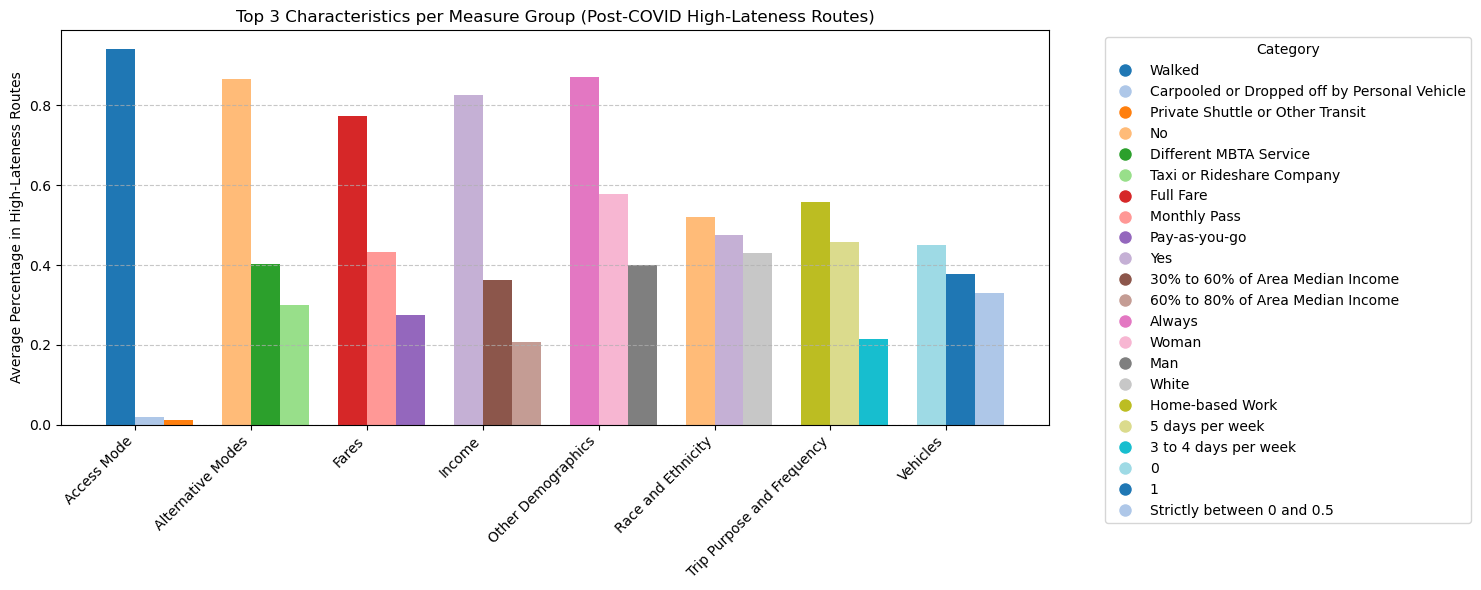

In [102]:
palette = sns.color_palette("tab20", n_colors=50)
unique_categories = top_categories["category"].unique()
category_to_color = {cat: palette[i % len(palette)] for i, cat in enumerate(unique_categories)}

# Add position within each measure_group to control bar placement
top_categories["Position"] = top_categories.groupby("measure_group").cumcount()

# Set plot
fig, ax = plt.subplots(figsize=(15, 6))
groups = top_categories["measure_group"].unique()
x = np.arange(len(groups))  # one x per group
width = 0.25  # width of each bar

# Plot bars manually
for i in range(top_categories["Position"].max() + 1):
    subset = top_categories[top_categories["Position"] == i]
    bars = ax.bar(
        x + (i - 0.5) * width,  # shift bar position within each group
        subset["weighted_percent"],
        width=width,
        color=[category_to_color[cat] for cat in subset["category"]],
        label=None
    )

# X-axis setup
ax.set_xticks(x)
ax.set_xticklabels(groups, rotation=45, ha="right")
ax.set_ylabel("Average Percentage in High-Lateness Routes")
ax.set_title("Top 3 Characteristics per Measure Group (Post-COVID High-Lateness Routes)")

# Custom legend
handles = [plt.Line2D([0], [0], marker='o', color='w', label=cat,
                      markerfacecolor=color, markersize=10)
           for cat, color in category_to_color.items()]
ax.legend(handles=handles, title="Category", bbox_to_anchor=(1.05, 1), loc='upper left')

ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [53]:
# display the top categories
top_10 = category_analysis.head(10)
print("Top 10 Categories with Highest Average Percentages in High-Lateness Routes (Post-COVID):\n")
print(top_10.to_string(index=False))

Top 10 Categories with Highest Average Percentages in High-Lateness Routes (Post-COVID):

    measure_group                                     category  weighted_percent
      Access Mode         Bike, Scooter or Other Micromobility          0.011170
      Access Mode Carpooled or Dropped off by Personal Vehicle          0.018487
      Access Mode                                  Drove Alone          0.004573
      Access Mode             Private Shuttle or Other Transit          0.012638
      Access Mode                    Taxi or Rideshare Company          0.011245
      Access Mode                                     The RIDE          0.004762
      Access Mode                                       Walked          0.941235
Alternative Modes        Bike, Scooter, or Other Micromobility          0.075348
Alternative Modes                       Different MBTA Service          0.402469
Alternative Modes                                  Drive Alone          0.182419


In [29]:
print(df_post.columns.tolist())


['aggregation_level', 'service_mode', 'reporting_group', 'measure_group', 'measure', 'category', 'weighted_percent', 'ObjectId', 'full_category']


In [55]:
df_post["full_category"] = df_post["measure"] + ": " + df_post["category"]
df_post["percentage"] = df_post["percentage"] * 100

# NOW filter using the updated df_post
df_analysis = df_post[df_post["reporting_group"].isin(above_avg_routes["route_id"])]


In [56]:
# Pivot to get categories as features
pivot_df = df_analysis.pivot_table(index='reporting_group', 
                                    columns='full_category', 
                                    values='percentage', 
                                    aggfunc='mean').fillna(0)

# merge in lateness
pivot_df = pivot_df.merge(lateness_df[["route_id", "average_lateness"]], 
                          left_index=True, right_on="route_id", how="left")
pivot_df = pivot_df.drop(columns="route_id")

In [57]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_features = scaler.fit_transform(pivot_df)

#normalizing the features
from sklearn.cluster import KMeans

#kmeans
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(scaled_features)

pivot_df["cluster"] = clusters

,Ability to Understand English: Always,Ability to Understand English: Never,Ability to Understand English: Often,Ability to Understand English: Prefer not to say,Ability to Understand English: Sometimes,"Access to First MBTA Service: Bike, Scooter or Other Micromobility",Access to First MBTA Service: Carpooled or Dropped off by Personal Vehicle,Access to First MBTA Service: Drove Alone,Access to First MBTA Service: Private Shuttle or Other Transit,Access to First MBTA Service: Taxi or Rideshare Company,...,Trip Purpose: Home-based Social Activity,Trip Purpose: Home-based Work,Trip Purpose: Non-home Based,Usable Cars: 0,Usable Cars: 1,Usable Cars: 2,Usable Cars: 3 or more,Used Alternative Mode: No,Used Alternative Mode: Yes,average_lateness
cluster,,,,,,,,,,,,,,,,,,,,,
0,8319.263495,159.412301,703.062701,32.189347,786.072154,122.695244,192.997283,28.199114,148.180789,128.307382,...,739.232601,5173.047597,805.782685,4386.715473,3881.272131,1447.573388,284.439009,8695.870451,1304.129549,241.591969
1,9004.388051,86.013814,417.328018,26.636086,465.634030,98.308783,182.412166,51.146403,85.308280,86.988400,...,738.059337,6114.872977,992.820577,4622.908776,3586.943139,1528.464266,261.683818,8606.649770,1393.350230,284.763678
2,9050.680900,66.709830,474.871450,0.000000,407.737820,32.610780,141.936490,0.000000,68.877560,214.732740,...,1021.211820,4224.002150,888.194310,3720.653770,4432.102920,1623.970670,223.272650,8802.135890,1197.864110,350.756948


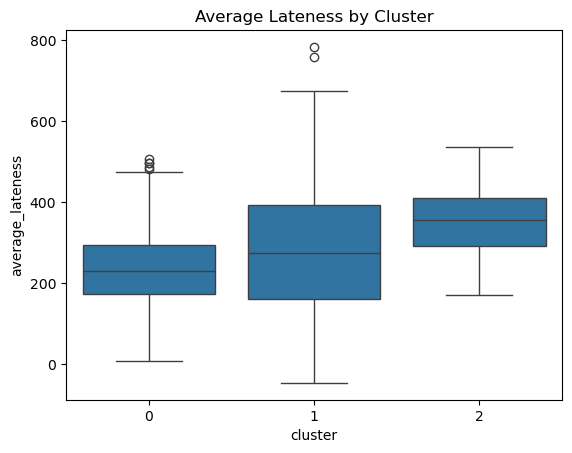

In [58]:
# Show average feature values per cluster
cluster_summary = pivot_df.groupby("cluster").mean()
display(cluster_summary)


sns.boxplot(data=pivot_df, x="cluster", y="average_lateness")
plt.title("Average Lateness by Cluster")
plt.show()

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Reduce to 2D using PCA
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(scaled_features)

# Create a DataFrame with 2D coordinates and cluster labels
visual_df = pd.DataFrame(reduced_features, columns=["PCA1", "PCA2"])
visual_df["Cluster"] = clusters

# Plot the clusters in 2D space
plt.figure(figsize=(10, 6))
sns.scatterplot(data=visual_df, x="PCA1", y="PCA2", hue="Cluster", palette="Set2", s=70)
plt.title("K-Means Clustering of Bus Routes (Demographics) - PCA Projection")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster")
plt.grid(True)
plt.show()


In [ ]:
cluster_summary = pivot_df.groupby("cluster").mean()
display(cluster_summary)

In [59]:
#pre covid lateness using the survey dataset 2015-2017 and the departure arrivals from 2018 (closest dataset)
precovid_folder = "/Users/sarahyuhan/BostonBusEquity/2015-2017-tables"
file_paths = glob.glob(os.path.join(precovid_folder, '*export.xlsx'))

df_list = [pd.read_excel(file) for file in file_paths]
df_pre = pd.concat(df_list, ignore_index=True)

# Convert route_id to match post-COVID dataset format
above_avg_routes_2018 = above_avg_routes_2018.copy()
above_avg_routes_2018["route_id"] = above_avg_routes_2018["route_id"].astype(str)

df_pre["Route"] = df_pre["Route"].astype(str)

# Merge post-COVID data with routes that had above-average lateness
df_analysis2 = df_pre[df_pre["Route"].isin(above_avg_routes_2018["route_id"])]

print("\nRoutes with Higher Than Average Lateness 2018:")
display(above_avg_routes_2018) 


Routes with Higher Than Average Lateness 2018:


,route_id,total_lateness,trip_count,average_lateness
0,01,5233144.0,11810,443.111262
4,08,1137104.0,4410,257.846712
8,101,1296259.0,4063,319.039872
9,104,989244.0,2687,368.159285
10,105,267470.0,834,320.707434
...,...,...,...,...
4523,114,38620.0,132,292.575758
4527,120,433151.0,1290,335.775969
4543,192,19402.0,48,404.208333
4544,193,19791.0,46,430.239130


In [ ]:
#heatmap

In [60]:
precovid_folder = "/Users/sarahyuhan/BostonBusEquity/2015-2017-tables"
file_paths = glob.glob(os.path.join(precovid_folder, '*export.xlsx'))

# Store top categories per table
top_categories_per_table = {}

# Make sure route IDs are string for comparison
above_avg_routes_2018["route_id"] = above_avg_routes_2018["route_id"].astype(str)

for file_path in file_paths:
    df = pd.read_excel(file_path)

    # Ensure column names are stripped of whitespace
    df.columns = df.columns.str.strip()
    
    # Ensure Route column exists and is string
    if "Route" not in df.columns:
        continue
    df["Route"] = df["Route"].astype(str)

    # Filter to routes with high lateness
    df_filtered = df[df["Route"].isin(above_avg_routes_2018["route_id"])].copy()

    # Drop non-numeric columns except Route
    numeric_cols = df_filtered.drop(columns=["Route"]).select_dtypes(include='number').columns
    if len(numeric_cols) == 0:
        continue  # Skip if no numeric columns

    # Calculate percentages per row (per route)
    df_percentages = df_filtered.copy()
    row_sums = df_filtered[numeric_cols].sum(axis=1)
    df_percentages[numeric_cols] = df_filtered[numeric_cols].div(row_sums, axis=0) * 100

    # Aggregate: average percentage across all high-lateness routes for each category
    category_averages = df_percentages[numeric_cols].mean().sort_values(ascending=False)

    # Store the result
    table_name = os.path.basename(file_path).replace("_data_export.xlsx", "")
    top_categories_per_table[table_name] = category_averages

# Display top categories for each survey type
for table, series in top_categories_per_table.items():
    print(f"\nTop categories for {table}:")
    display(series.head(2))



Top categories for route:


Trip Purpose: Home-based work    37.186970
Trip Frequency: 5 days a week    28.654947
dtype: float64


Top categories for income:


Low-income: No     32.819609
Low-income: Yes    17.197155
dtype: float64


Top categories for other_demographics:


English Ability: Always    31.717533
Gender: Woman              19.855640
dtype: float64


Top categories for auto_availability:


License: Yes    24.894646
Vehicles: 1     13.943647
dtype: float64


Top categories for access_mode:


Access: Walked or bicycled           47.297170
Previous Mode: Rail rapid transit    34.143996
dtype: float64


Top categories for alt_mode:


Use Alt Mode: Yes                          26.004475
Alt Mode: Take a different MBTA service    20.815509
dtype: float64


Top categories for race_and_ethnicity:


Hispanic: No    27.763540
Race: White     20.316887
dtype: float64


Top categories for fares:


Pay-Per-Ride Type: Charlie Card (plastic)     27.005650
Monthly Pass Type: LinkPass or Express Bus    25.019041
dtype: float64

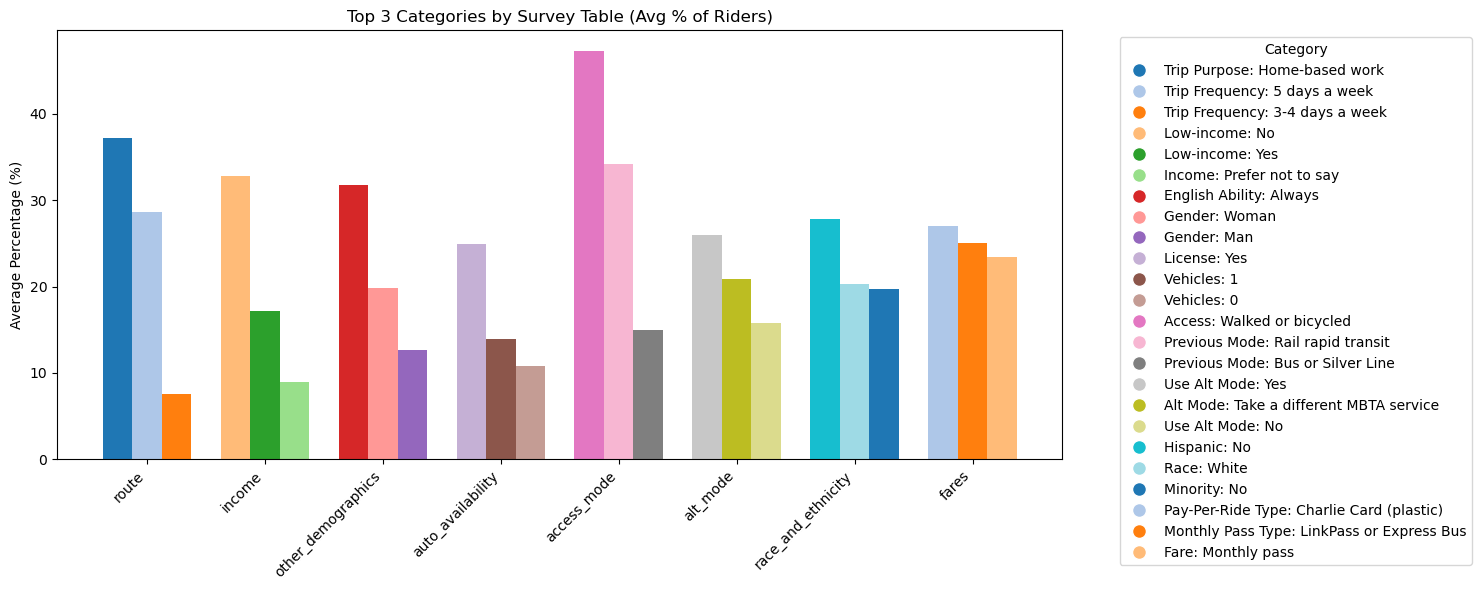

In [61]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Use seaborn for better color palette
palette = sns.color_palette("tab20", n_colors=50)

# Prepare flat data: one row per category per table
data_for_plot = []

for table, series in top_categories_per_table.items():
    top3 = series.head(3)
    for category, percent in top3.items():
        data_for_plot.append({
            "Survey Table": table,
            "Category": category,
            "Percentage": percent
        })

plot_df = pd.DataFrame(data_for_plot)

# Assign unique colors per category
unique_categories = plot_df["Category"].unique()
category_to_color = {cat: palette[i % len(palette)] for i, cat in enumerate(unique_categories)}

# Pivot to control bar positions
plot_df["Position"] = plot_df.groupby("Survey Table").cumcount()

# Set plot
fig, ax = plt.subplots(figsize=(15, 6))

x = np.arange(plot_df["Survey Table"].nunique())
width = 0.25

# Draw bars
for i in range(3):
    subset = plot_df[plot_df["Position"] == i]
    bars = ax.bar(
        x + (i - 1) * width,
        subset["Percentage"],
        width=width,
        color=[category_to_color[cat] for cat in subset["Category"]],
        label=None  # skip label here, we'll build legend manually
    )

# X-axis setup
ax.set_xticks(x)
ax.set_xticklabels(plot_df["Survey Table"].unique(), rotation=45, ha="right")
ax.set_ylabel("Average Percentage (%)")
ax.set_title("Top 3 Categories by Survey Table (Avg % of Riders)")

# Build custom legend
handles = [plt.Line2D([0], [0], marker='o', color='w', label=cat,
                      markerfacecolor=color, markersize=10)
           for cat, color in category_to_color.items()]
ax.legend(handles=handles, title="Category", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


In [70]:
print(above_avg_routes_2018.columns)


Index(['route_id', 'total_lateness', 'trip_count', 'average_lateness'], dtype='object')


In [82]:
print(df_post.columns)

Index(['aggregation_level', 'service_mode', 'reporting_group', 'measure_group',
       'measure', 'category', 'percentage', 'objectid', 'full_category'],
      dtype='object')


In [91]:
# now taking the top 3 categories from pre covid, and looking at the same categories in post covid on the 
# same routes in order to calculate the percent change and directly compare
# Step 1: Clean df_post
df_post.columns = df_post.columns.str.strip().str.lower()
df_post['full_category'] = df_post['measure_group'].str.strip() + ": " + df_post['category'].str.strip()

# Step 2: Filter to high-lateness routes
above_avg_route_ids = above_avg_routes_2018["route_id"].astype(str).unique()
df_post_filtered = df_post[df_post["reporting_group"].astype(str).isin(above_avg_route_ids)]

# Step 3: Aggregate post-COVID percentages
post_averages = (
    df_post_filtered.groupby("full_category")["percentage"]
    .mean()
    .reset_index()
    .rename(columns={"percentage": "post_covid_percent"})
)

# Step 4: Clean and collect top pre-COVID categories
records = []
for table, series in top_categories_per_table.items():
    for category, pre_pct in series.head(2).items():
        records.append({
            "table": table,
            "full_category": category.strip(),  # clean here too
            "pre_covid_percent": pre_pct
        })

df_top_categories = pd.DataFrame(records)

In [92]:
def normalize(text):
    return str(text).strip().lower().replace("–", "-")  # Normalize dash too

# Apply normalization
df_post["full_category_clean"] = df_post["full_category"].apply(normalize)
df_top_categories["full_category_clean"] = df_top_categories["full_category"].apply(normalize)


In [93]:
# Step 5: Final cleanup before merge
post_averages["full_category"] = post_averages["full_category"].str.strip()
df_top_categories["full_category"] = df_top_categories["full_category"].str.strip()

# Step 6: Merge and compute change
comparison_df = pd.merge(
    df_top_categories,
    post_averages.rename(columns={"full_category": "full_category_clean"}),
    on="full_category_clean",
    how="left"
)


comparison_df["percent_change"] = (
    (comparison_df["post_covid_percent"] - comparison_df["pre_covid_percent"]) /
    comparison_df["pre_covid_percent"]
) * 100

# Step 7: Show result
display(comparison_df.sort_values(by="percent_change", ascending=False))


,table,full_category,pre_covid_percent,full_category_clean,post_covid_percent,percent_change
0,route,Trip Purpose: Home-based work,37.186970,trip purpose: home-based work,NaN,NaN
1,route,Trip Frequency: 5 days a week,28.654947,trip frequency: 5 days a week,NaN,NaN
2,income,Low-income: No,32.819609,low-income: no,NaN,NaN
3,income,Low-income: Yes,17.197155,low-income: yes,NaN,NaN
4,other_demographics,English Ability: Always,31.717533,english ability: always,NaN,NaN
5,other_demographics,Gender: Woman,19.855640,gender: woman,NaN,NaN
6,auto_availability,License: Yes,24.894646,license: yes,NaN,NaN
7,auto_availability,Vehicles: 1,13.943647,vehicles: 1,NaN,NaN
8,access_mode,Access: Walked or bicycled,47.297170,access: walked or bicycled,NaN,NaN
9,access_mode,Previous Mode: Rail rapid transit,34.143996,previous mode: rail rapid transit,NaN,NaN


In [106]:
# need to fix here: some categories don't match up (english ability: always vs ability to understand english)
# also need to fix loading the post covid percentages into the table for percent change comparison
postcovid = "/Users/sarahyuhan/BostonBusEquity/2023.csv"
df_post = pd.read_csv(postcovid)

# Filter only bus routes
df_post = df_post[df_post['service_mode'] == 'Bus']
df_post.columns = df_post.columns.str.strip().str.lower()
df_post.rename(columns={'weighted_percent': 'percentage'}, inplace=True)
df_post["percentage"] = df_post["percentage"] * 100

df_post['full_category'] = df_post['measure'] + ": " + df_post['category']

# ✅ Fix: Redefine df_analysis here after cleaning df_post
above_avg_route_ids = above_avg_routes["route_id"].astype(str).unique()
df_analysis = df_post[df_post["reporting_group"].isin(above_avg_route_ids)]

# Step 1: Group post-COVID data
category_analysis = df_analysis.groupby(["measure_group", "category"])["percentage"].mean().reset_index()
category_analysis["full_category"] = category_analysis["measure_group"].str.strip() + ": " + category_analysis["category"].str.strip()

def normalize(text):
    return str(text).strip().lower().replace("–", "-").replace("—", "-")

category_analysis["full_category_clean"] = category_analysis["full_category"].apply(normalize)

# Step 2: Prepare pre-COVID top categories
records = []
for table, series in top_categories_per_table.items():
    for category, pre_pct in series.head(2).items():
        records.append({
            "table": table,
            "full_category": category.strip(),
            "pre_covid_percent": pre_pct,
            "full_category_clean": normalize(category)
        })

df_top_categories = pd.DataFrame(records)

# Step 3: Merge post-COVID values
comparison_df = pd.merge(
    df_top_categories,
    category_analysis[["full_category_clean", "percentage"]].rename(columns={"percentage": "post_covid_percent"}),
    on="full_category_clean",
    how="left"
)

# Step 4: Calculate percent change
comparison_df["percent_change"] = (
    (comparison_df["post_covid_percent"] - comparison_df["pre_covid_percent"]) /
    comparison_df["pre_covid_percent"]
) * 100

# Step 5: Display
display(comparison_df.sort_values(by="percent_change", ascending=False))


,table,full_category,pre_covid_percent,full_category_clean,post_covid_percent,percent_change
7,auto_availability,Vehicles: 1,13.943647,vehicles: 1,37.647093,169.994589
0,route,Trip Purpose: Home-based work,37.186970,trip purpose: home-based work,NaN,NaN
1,route,Trip Frequency: 5 days a week,28.654947,trip frequency: 5 days a week,NaN,NaN
2,income,Low-income: No,32.819609,low-income: no,NaN,NaN
3,income,Low-income: Yes,17.197155,low-income: yes,NaN,NaN
4,other_demographics,English Ability: Always,31.717533,english ability: always,NaN,NaN
5,other_demographics,Gender: Woman,19.855640,gender: woman,NaN,NaN
6,auto_availability,License: Yes,24.894646,license: yes,NaN,NaN
8,access_mode,Access: Walked or bicycled,47.297170,access: walked or bicycled,NaN,NaN
9,access_mode,Previous Mode: Rail rapid transit,34.143996,previous mode: rail rapid transit,NaN,NaN


In [ ]:
df_top_categories = df_top_categories.merge(post_averages, on="full_category", how="left")
df_top_categories["percent_change"] = df_top_categories["post_covid_percent"] - df_top_categories["pre_covid_percent"]

# Optional: Sort if needed
df_top_categories = df_top_categories.sort_values(by="percent_change", ascending=False)

# Step 6: Plot
plt.figure(figsize=(14, 6))
sns.barplot(
    data=df_top_categories,
    x="table",
    y="percent_change",
    hue="full_category"
)

# Formatting
plt.title("Percent Change from Pre-COVID to Post-COVID (Top Categories by Table)")
plt.ylabel("Percentage Point Change")
plt.xlabel("Survey Table")
plt.axhline(0, color='gray', linestyle='--')
plt.legend(title="Category", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()